In [5]:
import torch
import os
import torch.nn.functional as F
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm


In [6]:

# --- 1. Reuse Model and Dataset Classes ---
# Make sure these are identical to the ones in your training script.

class AdvancedGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(AdvancedGNN, self).__init__()
        self.conv1 = GATConv(num_node_features, 64, heads=8, dropout=0.6)
        self.bn1 = BatchNorm(64 * 8)
        self.conv2 = GATConv(64 * 8, 128, heads=1, dropout=0.6)
        self.bn2 = BatchNorm(128)
        self.conv3 = GATConv(128, 128, heads=1, dropout=0.6)
        self.bn3 = BatchNorm(128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

class MNISTGraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MNISTGraphDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self): return []
    @property
    def processed_file_names(self): return [f'data_{i}.pt' for i in range(60000)]
    def len(self): return len(self.processed_file_names)
    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'), weights_only=False)
        return data


In [7]:


# --- 2. Evaluation Function ---
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluating"):
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)


Using device: cuda
Trained advanced model weights loaded successfully.


Evaluating: 100%|██████████| 94/94 [00:24<00:00,  3.83it/s]
c:\Program Files\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Program Files\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Program Files\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1175
           1       0.00      0.00      0.00      1322
           2       0.00      0.00      0.00      1174
           3       0.09      0.00      0.01      1219
           4       0.00      0.00      0.00      1176
           5       0.05      0.06      0.05      1104
           6       0.11      0.99      0.20      1177
           7       0.00      0.00      0.00      1299
           8       0.00      0.00      0.00      1160
           9       0.00      0.00      0.00      1194

    accuracy                           0.10     12000
   macro avg       0.02      0.11      0.03     12000
weighted avg       0.02      0.10      0.03     12000



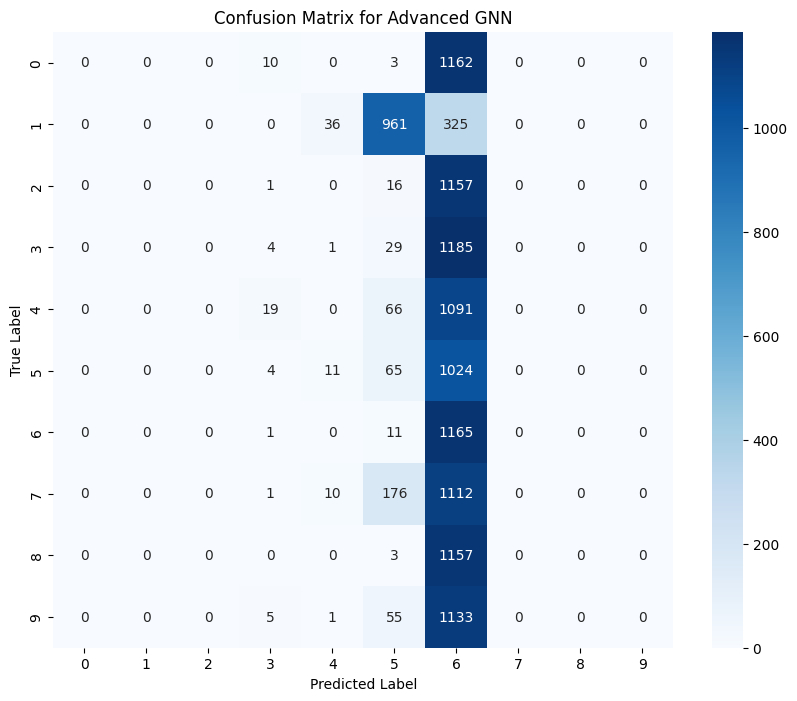

In [8]:

# --- 3. Main Execution Block ---
if __name__ == '__main__':
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # --- IMPORTANT ---
    # Replace the path below with the absolute path to your 'mnist_graphs' folder.
    ABSOLUTE_PATH_TO_DATA = r'A:\mnist_gnn\mnist_first_try\mnist_graphs'
    
    # Load the full dataset to get the correct test split
    full_dataset = MNISTGraphDataset(root=ABSOLUTE_PATH_TO_DATA)
    
    # Use the same random_state to ensure we get the exact same test set
    train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)
    test_dataset = full_dataset[test_indices]
    
    # Create DataLoader for the test set
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Initialize the model architecture
    model = AdvancedGNN(num_node_features=3, num_classes=10).to(device)
    
    # Load the saved weights
    model_path = 'advanced_gnn_model.pth'
    if not os.path.exists(model_path):
        print(f"Model file not found at {model_path}. Please run train_advanced_gnn.py first.")
    else:
        model.load_state_dict(torch.load(model_path))
        print("Trained advanced model weights loaded successfully.")

        # Evaluate the model
        predictions, true_labels = evaluate_model(model, test_loader, device)
        
        # --- Performance Metrics ---
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions))
        
        # Plotting the Confusion Matrix
        plt.figure(figsize=(10, 8))
        conf_matrix = confusion_matrix(true_labels, predictions)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix for Advanced GNN')
        plt.show()